In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
import time
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack
import datetime as dt

import math
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from hdbscan import HDBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 35, 40
%matplotlib inline

import matplotlib.cm as cm
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import __version__
from plotly import graph_objs as go
from plotly.graph_objs import *

## Читаем данные

In [10]:
df=pd.read_pickle('MG_Sales_customer.pickle',compression='gzip')

In [11]:
#---------------------------
#выбираем покупателей для дальнейшего анализа
sales_sum=df.groupby('Покупатель')['Количество'].sum().sort_values()
#выкидываем со слишком большими продажами (сводные карты) и тех кто купил один раз
sales_sum.drop(sales_sum[(sales_sum>sales_sum.tail(6)[0])].index, inplace=True)#|(sales_sum==1)
customers_name=list(sales_sum.index)
del sales_sum

#делаем выборку
select=df.loc[(df['Покупатель'].isin(customers_name))&(df['Дата']>=(dt.datetime(2016,1,7))),['Покупатель','ПокупательПол','ПокупательДатаРождения','ВидИзделия','ПодвидИзделия','СтильДизайна','ВидДизайна','ОсновнойКамень','ГруппаТовара','Коллекция','ЦветМеталла','ТоварСреднийВес','Размер','Вес','Количество','Сумма','Дата','ПокупательОтказОтСМС']]
del customers_name
del df

#Подготовка датасета
#ЦветМеталла=list(map(lambda xx: xx,list(select['ЦветМеталла'].unique())))
def codeMetall(_str):    
    for str_split in _str.lower().split():
        if str_split=='серебро': return 0
        if str_split=='золото': return 10
        if str_split=='зол.': return 11
        if str_split=='платина': return 20
        if str_split=='сплав': return -10
    return -20


select['ПокупательПолКод']=select['ПокупательПол'].map(lambda xx: {'Ж':0, 'М':1, '<Неопределено>':None}[xx])
select['ЦветМеталлаКод']=select['ЦветМеталла'].map(lambda xx: codeMetall(xx))
select['ПокупательПолКод'].fillna(select['ПокупательПолКод'].median(),inplace=True)
select['ПокупательГодРождения']=select['ПокупательДатаРождения'].dt.year
select['ПокупательГодРождения']=select['ПокупательГодРождения'].map(lambda xx: None if xx<1917 else xx)
select['ПокупательГодРождения']=select['ПокупательГодРождения'].map(lambda xx: None if xx>2010 else xx)
#select['ПокупательГодРождения'].fillna(select['ПокупательГодРождения'].median(),inplace=True)
select.drop(['ПокупательДатаРождения','ЦветМеталла','ПокупательПолКод'],  axis=1, inplace=True)
#выборка колонок
numerical_columns = [c for c in select.columns if select[c].dtype.name != 'object']
categorial_columns = [c for c in select.columns if select[c].dtype.name == 'object']

numerical_columns=list(set(numerical_columns)-(set(['ПокупательГодРождения','Дата','Сумма'])))
categorial_columns=list(set(categorial_columns)-(set(['ПокупательПол','ПокупательОтказОтСМС'])))



#Dummy-кодирование и шкалируем
lb_style = LabelBinarizer(sparse_output=True)
concList=[]
for col in categorial_columns:
    concList.append(lb_style.fit_transform(select[col]))    
concList.append(StandardScaler().fit_transform(select[numerical_columns]))#добавляем шклированные значения числовых переменных
X=hstack(concList)

del concList
print('shape ',X.shape)
print('Prepare finished')

shape  (131024, 65132)
Prepare finished


In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=int(math.sqrt(X.shape[1])), n_iter=5)
svd_representation = svd.fit_transform(X)
var1=np.cumsum(np.round(svd.explained_variance_ratio_, decimals=5)*100)
#plt.plot(var1[-50:])

#расчитываем оптимальное количество компонент
#более 90% дисперсии и шаг приращения каждой следующей компоненты <10^-4
optimal_n=np.intersect1d(np.argwhere(var1>90.),np.argwhere(svd.explained_variance_ratio_<=10**-4))[0]
print(optimal_n)#171

if optimal_n==None:
    raise 'Not enough n_components!'

svd = TruncatedSVD(n_components=optimal_n, n_iter=7)
svd_representation = svd.fit_transform(X)
print('reduced')
del var1

133
reduced


In [13]:
del X

In [23]:
n_clusters=7


hdb_t1 = time.time()
hdb = MiniBatchKMeans(n_clusters=n_clusters,max_iter=150,max_no_improvement=15,batch_size=165,tol=.01,n_init=5,random_state=17).fit(svd_representation)
#hdb = MiniBatchKMeans(n_clusters=n_clusters,max_iter=150,max_no_improvement=15,batch_size=165,n_init=3,random_state=17).fit(svd_representation)



hdb_elapsed_time = time.time() - hdb_t1
print('MiniBatchKMeans Elapsed time to cluster: %.4f s' % (hdb_elapsed_time))

MiniBatchKMeans Elapsed time to cluster: 0.5551 s


Elapsed time to cluster:    0.8 m
For n_clusters = 7 The average silhouette_score is : 0.181334415755
Negative silhouette count:  962 ,  3.67 %
Плохой результат силуэта при кластеризации


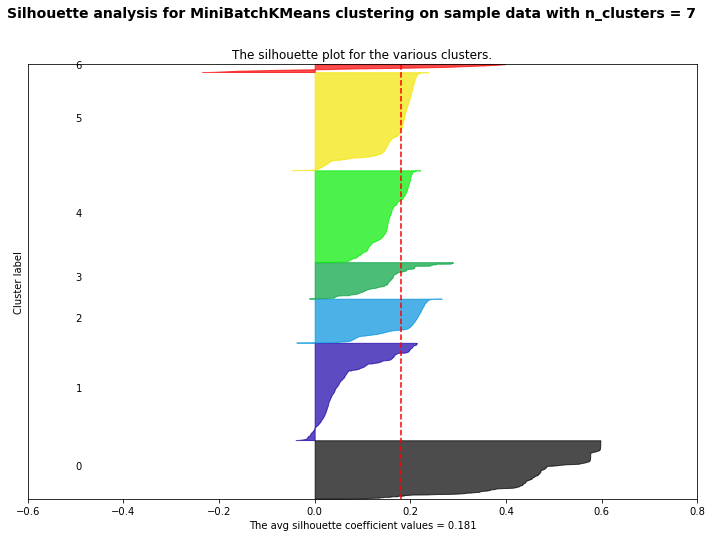

Elapsed time to cluster:    0.8 m
For n_clusters = 7 The average silhouette_score is : 0.18059711901
Negative silhouette count:  814 ,  3.11 %
Плохой результат силуэта при кластеризации


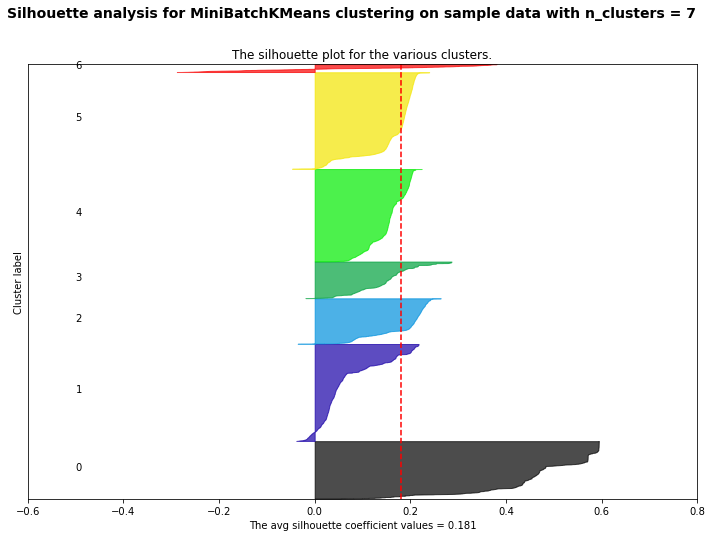

In [24]:
from sklearn.model_selection import ShuffleSplit
#svd_representation=X.copy()

ss = ShuffleSplit(n_splits=2, train_size=int(svd_representation.shape[0]*.2))
subs= ss.split(svd_representation)#,hdb.labels_

for index in subs:
    X=svd_representation[index[0]]#.tocsr()
    cluster_labels=hdb.labels_[index[0]]
                        
    hdb_t1 = time.time()
    
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 8)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax1.set_xlim([-.5, .5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 12])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('Elapsed time to cluster: %6.1f m' % ((time.time()-hdb_t1)/60))
    print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    n_len=len(sample_silhouette_values[sample_silhouette_values<0])
    one_per=len(sample_silhouette_values)/100
    percent=round(n_len/one_per,2)
    print('Negative silhouette count: ',n_len,', ',percent,'%')
    if percent>=2: print('Плохой результат силуэта при кластеризации')#raise Exception
    
    y_lower = 12
    for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]
    
                ith_cluster_silhouette_values.sort()
    
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i
    
                color = cm.spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)
    
                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.5, y_lower + 0.5 * size_cluster_i, str(i))
    
                # Compute the new y_lower for next plot
                y_lower = y_upper + 12  # 10 for the 0 samples
    
    set_xlabel="The avg silhouette coefficient values = "+str(round(silhouette_avg,3))
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel(set_xlabel)
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(list(np.arange(-.6,1,.2)))
    
    plt.suptitle(("Silhouette analysis for MiniBatchKMeans clustering on sample data "
                          "with n_clusters = %d" % n_clusters),
                         fontsize=14, fontweight='bold')
    
    plt.show()
    
    del X
    del cluster_labels

In [8]:
select['ЦветМеталлаКод']=select['ЦветМеталлаКод'].map(lambda xx: {0: 'серебро', 10: 'золото', 11: 'золото', 20: 'платина',-10: 'сплав', -20: 'прочее'}[xx])
#select['ПокупательПолКод']=select['ПокупательПолКод'].map(lambda xx: {0: 'Ж', 1: 'М'}[xx])

In [9]:
comma=','

#Выводим данные по кластерам в сводную таблицу
clusters_data=pd.DataFrame(columns=select.columns)
    
for cl in range(hdb.cluster_centers_.shape[0]):
    tsel=tsel=select.loc[hdb.labels_==cl]#выборка по кластеру
    sel=tsel.describe(include='all')
    clust_info=sel.loc[['top','mean']]
    
    
    cat_lbls=list(clust_info.loc['top',pd.notnull(clust_info.loc['top'])].index)#категориальные переменные
    #Рассчитываем три максимальных значения
    for col in cat_lbls:
        if col=='ПокупательПол': continue
        
        if col=='ПодвидИзделия':
            str_vals=[]            
            for val in clust_info.loc['top','ВидИзделия'].split(','):
                str_vals.append(tsel.loc[tsel['ВидИзделия']==val].groupby(col)['Покупатель'].count().sort_values(ascending=False).head(1).index.values[0])
        else:
            str_vals=list(tsel.groupby(col)['Покупатель'].count().sort_values(ascending=False).head(3).index)
            
        #clust_info.loc['top',col]=str_vals.translate(trantab)
        try:
            clust_info.loc['top',col]=comma.join(str_vals)
        except:
            clust_info.loc['top',col]=''
            
    
    clusters_data.loc[cl+1]=pd.concat([clust_info.fillna('').sum(axis=0),clust_info.fillna(0).sum(axis=0)])
    
    sex_count=tsel.groupby('ПокупательПол')['Покупатель'].nunique()
    perc1=sex_count.sum()/100
    clusters_data.loc[cl+1,'М (%)']=round(sex_count['М']/perc1,2)
    clusters_data.loc[cl+1,'Ж (%)']=round(sex_count['Ж']/perc1,2)
    
    sms_count=tsel.groupby('ПокупательОтказОтСМС')['Покупатель'].nunique()
    perc1=sms_count.sum()/100
    clusters_data.loc[cl+1,'Согласные с рассылкой СМС всего (%)']=round(sms_count[False]/perc1,2)
    
    sales_count=tsel.groupby('Покупатель')['Дата'].nunique()#Покупатели по датам    
    cust_names=sales_count[sales_count>1].index.values#Имена покупателей совершивших более одной покупки
    sms_count=tsel.loc[(tsel['Покупатель'].isin(cust_names))].groupby('ПокупательОтказОтСМС')['Покупатель'].nunique()
    perc1=sms_count.sum()/100
    clusters_data.loc[cl+1,'Согласные с рассылкой СМС при повторных покупках (%)']=round(sms_count[False]/perc1,2)
    
    #clusters_data.loc[cl+1,'Количество']=sel.loc['count','Покупатель']
    #clusters_data.loc[cl+1,'РазбросСумма']=sel.loc['std','Сумма']
    
    clusters_data.loc[cl+1,'Средний возраст (лет)']=dt.datetime.now().year-int(clusters_data.loc[cl+1,'ПокупательГодРождения'])
    
    clusters_data.loc[cl+1,'Уникальных покупателей в кластере']=sel.loc['unique','Покупатель']
    sales_count=tsel.groupby('Покупатель')['Количество'].sum()
    clusters_data.loc[cl+1,'Кол-во купленных изделий среднее']=sales_count.mean()
    
    sales_count=tsel.groupby('Покупатель')['Дата'].nunique()#Покупатели по датам
    clusters_data.loc[cl+1,'Число покупок среднее']=sales_count.mean()
    clusters_data.loc[cl+1,'2 Покупки']=sales_count[sales_count==2].shape[0]
    clusters_data.loc[cl+1,'3 Покупки']=sales_count[sales_count==3].shape[0]
    clusters_data.loc[cl+1,'4 Покупки']=sales_count[sales_count==4].shape[0]
    clusters_data.loc[cl+1,'5 Покупок']=sales_count[sales_count==5].shape[0]
    clusters_data.loc[cl+1,'>5 Покупок']=sales_count[sales_count>5].shape[0]
    
    
    sales_count_sum=tsel.groupby('Покупатель')['Сумма'].sum()
    clusters_data.loc[cl+1,'Средний чек']=(sales_count_sum/sales_count).mean()
    clusters_data.loc[cl+1,'Цена изделия средняя']=sel.loc['50%','Сумма'] 
    
    clusters_data.loc[cl+1,'Размер среднее']=clusters_data.loc[cl+1,'Размер']
    clusters_data.loc[cl+1,'Вес среднее']=clusters_data.loc[cl+1,'Вес']
    
    
clusters_data.drop(['ПокупательГодРождения','Количество','ПокупательОтказОтСМС','ПокупательПол','Сумма','ТоварСреднийВес','Размер','Вес','Дата'],axis=1,inplace=True)
#clusters_data.sort_values('Уникальных покупателей в кластере',inplace=True, ascending=False)

#clusters_data=clusters_data.reset_index()
#clusters_data.drop('index', axis=1, inplace=True)
clusters_data.index = range(1,clusters_data.shape[0]+1)

for col in cat_lbls:
    if col=='Покупатель':
        clusters_data=clusters_data.rename(columns={col: col+' - основные в кластере'})
    else:
        clusters_data=clusters_data.rename(columns={col: col+' - 3 самых популярных'})
    
    
    
writer = pd.ExcelWriter('Кластера по продажам.xlsx')
clusters_data.to_excel(writer,'Sheet1',index_label='№ кластера')
writer.save()

clusters_data

,Покупатель - основные в кластере,ВидИзделия - 3 самых популярных,ПодвидИзделия - 3 самых популярных,СтильДизайна - 3 самых популярных,ВидДизайна - 3 самых популярных,ОсновнойКамень - 3 самых популярных,ГруппаТовара - 3 самых популярных,Коллекция - 3 самых популярных,ЦветМеталлаКод - 3 самых популярных,М (%),...,Число покупок среднее,2 Покупки,3 Покупки,4 Покупки,5 Покупок,>5 Покупок,Средний чек,Цена изделия средняя,Размер среднее,Вес среднее
1,"Полунин Александр Юрьевич,Филлипова Анна Влади...","Серьги,Подвеска,Брошь","Серьги с англ. замком,Прочие подвески,Прочие б...","Classic,Fashion,<Неопределено>","Цветники с обсыпкой,Цветники - одинарники,Флора","Топаз,Гранат,Бриллиант","3 группа,2 группа,1 группа","Топазы с фианитом,Гранаты с фианитом,Бриллианты",золото,28.83,...,1.308796,3318.0,809.0,303.0,152.0,220.0,18635.619570,13038.0,0.000454,3.169910
2,"Щербакова Марина,Григорьева Татьяна Ивановна,Ч...","Кольцо,Браслет,Колье","Прочие кольца,Браслеты с камнями,Колье","Classic,Fashion,<Неопределено>","Флора,Цветники - одинарники,Цветники с обсыпкой","Фианит,Эмаль,Микс","4 группа,2 группа,Прочее","Серебряный Век,Morgan de toi,Ted Lapidus","серебро,прочее,сплав",17.34,...,1.298307,1353.0,363.0,137.0,53.0,106.0,2518.872916,1665.0,21.527357,4.885734
3,"Хомченко Светлана,Базарова Алла Юрьевна,Козло...","Кольцо,Браслет,Колье","Прочие кольца,Браслеты с камнями,Колье","Classic,Fashion,Russian trad.","Цветники с обсыпкой,Цветники - одинарники,Флора","Топаз,Гранат,Бриллиант","3 группа,1 группа,2 группа","Топазы с фианитом,Гранаты с фианитом,Бриллианты","золото,платина",33.90,...,1.249422,2776.0,632.0,239.0,138.0,147.0,15432.205862,10392.0,18.675434,2.893756
4,"Топоркова Ольга Васильевна,Базарова Алла Юрьев...","Цепь,Шнурок,Браслет","Плетеные цепи,шнурок,Дутые браслеты","Classic,<Неопределено>,Fashion","Дизайн не присваивается,Символы,Classic","Б/К,Прочее,Фианит","2 группа,1 группа,4 группа","Цепи и браслеты,Акимов,Шнурки","серебро,золото",25.77,...,1.120079,1270.0,264.0,85.0,43.0,27.0,4885.337610,1932.0,46.968707,2.933098
5,"Базарова Алла Юрьевна,Фокин Александр Владимир...","Серьги,Подвеска,Кольцо","Серьги с англ. замком,Прочие подвески,Прочие к...","Classic,Fashion,<Неопределено>","Одинарники,Дизайн не присваивается,Символы","Фианит,Б/К,Жемчуг","2 группа,1 группа","С фианитом(с-ги,к-цо,подв,бр-т,колье),Изделия ...",золото,28.34,...,1.190755,2341.0,487.0,167.0,83.0,90.0,7398.300814,5735.0,5.976832,1.948141
6,"Вострухова Маргарита Федоровна,Дорцева Елена В...","Серьги,Подвеска,Брошь","Серьги с англ. замком,Прочие подвески,Прочие б...","Classic,Fashion,<Неопределено>","Флора,Фауна,Символы","Фианит,Эмаль,Б/К","4 группа,2 группа,Прочее","Серебряный Век,Акимов,Православие","серебро,прочее,сплав",17.78,...,1.370844,2577.0,785.0,340.0,167.0,213.0,2842.635951,1811.0,0.000981,4.105778
7,"Любушкина Анна,Булгакова Мария Владимировна,Ща...","Колье,Браслет,Часы","Колье,Браслеты с камнями,часы","Classic,Fashion,<Неопределено>","Classic,Дизайн не присваивается,Цветники - оди...","Фианит,Б/К,Жемчуг","4 группа,2 группа,3 группа","Серебряный Век,Часы Magic Time,Жемчуг","серебро,сплав,золото",22.23,...,1.085920,100.0,13.0,7.0,2.0,0.0,8266.059738,5404.0,22.386988,32.979880


select.loc[hdb_labels==0].groupby('ВидИзделия')['Количество'].sum().sort_values(ascending=False)

In [ ]:
sms_count=select.groupby('ПокупательОтказОтСМС')['Покупатель'].nunique()

In [ ]:
sms_count

In [ ]:
df.columns